# Описание
Исследую разные способы генерации целевого признака, произвожу сравнения

В качестве таргета беру ситуацию когда прирос на следующем периоде > 1%, а нижняя тень < 0.25%.

Я уже проверил, что в выброке всего 5% таких событий.

Идея делать классификацию не по закрытию бара, а по максимуму.
Мне кажется случаев когда нижняя тень < 0.25%, а верхняя > 1% больше чем с закрытием.
Это завтра посчитать в ноутбуке рисерча.

А отношение награда/риск это как бы мой гипераметр, который можно подбирать. Вместе с нижней тенью. Мне же по сути не важно что ловить, как размечать данные.

А основная суть такой разметки данных - это отбор событий когда в течении часа или любого другого периода потенциально положительное движение идет с существенным перекосом вероятности, как 4к1.


МО = 4 * 0.5 - 1 * 0.5 = 2 - 0.5 = 1.5 риска на сделку получается матожидание при угадайке алгоритма всего 50%

И точка безубытка когда МО = 0, где x - угадайка алгоритма
 
0 = 4 * x - 1 * (1 - x)

4х -1 - х = 0
3х = 1
Х = 33.33%

Т.е. При угадайке в 33.33% я буду в нуле при нулевых издержках.

Для соотношении доходность/риск как 5к1
5х - 1 - х = 0
Х = 25%



Т.е. Это что-то типа детекции спама или скорее определение редкой болезни. Только в моем случае ложно-положительные исходы нужно сводить к минимуму, пусть я не угадаю все исходы, но главное минимизировать ложно-положительные т.к. по ним я совершаю сделки и буду получать убытки.

И получается что для меня опастность представляют ложно положительные результаты, на них я теряю деньги. Мне лучше постоять в стороне.

Тут важно правильно подобрать метрику. 


# Import modules

In [1]:
# for use R2Score metrics
# !pip install tf-nightly

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8) 

from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# Load Data

In [3]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [6]:
df.index

DatetimeIndex(['2017-09-01 00:00:00', '2017-09-01 01:00:00',
               '2017-09-01 02:00:00', '2017-09-01 03:00:00',
               '2017-09-01 04:00:00', '2017-09-01 05:00:00',
               '2017-09-01 06:00:00', '2017-09-01 07:00:00',
               '2017-09-01 08:00:00', '2017-09-01 09:00:00',
               ...
               '2023-04-23 14:00:00', '2023-04-23 15:00:00',
               '2023-04-23 16:00:00', '2023-04-23 17:00:00',
               '2023-04-23 18:00:00', '2023-04-23 19:00:00',
               '2023-04-23 20:00:00', '2023-04-23 21:00:00',
               '2023-04-23 22:00:00', '2023-04-23 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=49337, freq=None)

In [7]:
# df = df.asfreq('H')
# df = df.asfreq('H') # этот вариант сработает, но на месте пропусков появятся NaN записи

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


# Feature Enginiring
Логарифмирую все признаки

In [9]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

In [10]:
df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [11]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,
2017-09-01 00:00:00,5.952698,5.962911,5.952698,5.962911,5.093614,4.875197
2017-09-01 01:00:00,5.962782,5.976503,5.959793,5.969653,5.516366,5.568345
2017-09-01 02:00:00,5.973504,5.977340,5.964761,5.968401,5.292443,5.416100
2017-09-01 03:00:00,5.970496,5.974140,5.968349,5.968349,4.952732,4.927254
2017-09-01 04:00:00,5.972919,5.977036,5.960077,5.966993,4.910144,4.852030
...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [12]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [13]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

In [14]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log,Low_Shad_log,High_Shad_log,Log_Return
Datetime,,,,,,,,,
2017-09-01 00:00:00,5.952698,5.962911,5.952698,5.962911,5.093614,4.875197,0.000000,0.010213,0.010213
2017-09-01 01:00:00,5.962782,5.976503,5.959793,5.969653,5.516366,5.568345,0.002989,0.013721,0.006871
2017-09-01 02:00:00,5.973504,5.977340,5.964761,5.968401,5.292443,5.416100,0.008743,0.003836,-0.005104
2017-09-01 03:00:00,5.970496,5.974140,5.968349,5.968349,4.952732,4.927254,0.002147,0.003644,-0.002147
2017-09-01 04:00:00,5.972919,5.977036,5.960077,5.966993,4.910144,4.852030,0.012842,0.004117,-0.005926
...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668,0.000997,0.003022,-0.000146
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345,0.004592,0.003142,0.001299
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161,0.000698,0.005631,0.003121


In [15]:
def class_distribution(df, col):
    """ Метод для визуализации значений распределения для заданного категориального признака

    Args:
        df (_type_): датафрейм для анализа
        col (_type_): имя признака в датафрейме анализ по которому вывести

    Returns:
        _type_: _description_
    """
    class_df = pd.DataFrame({'%': (df[col].value_counts(True) * 100).round(2), 'Count': df[col].value_counts()})
    class_df.index.name = 'Class'
    class_df.sort_index(ascending=False, inplace=True)
    display(class_df)
    
    sns.countplot(data=df, x=col)
    plt.show()
    # return class_df

## LONG: Create Return as Category Target

### Категориальный признак показывающий что текущий бар вырос

In [16]:
df['Return_L_cat'] = np.where(df['Log_Return'] > 0, 1, 0)

,%,Count
Class,,
1,50.42,24877
0,49.58,24460


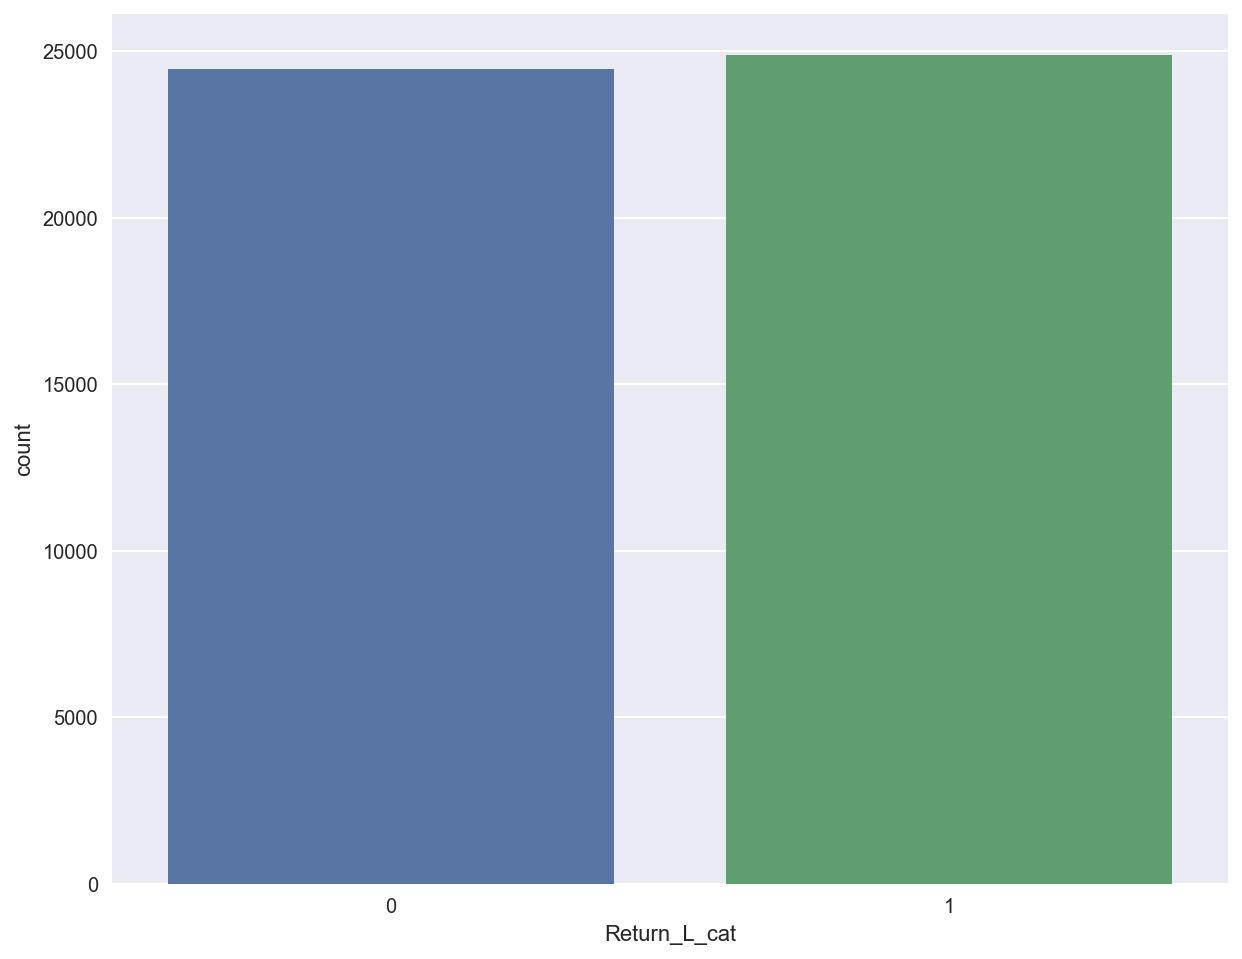

In [17]:
class_distribution(df, 'Return_L_cat')

В таком виде классы полностью сбалансированны, посмотрим что будет после разделения

### Категориальный признак показывающий, что текущий бар вырос минимум на 1%

In [18]:
df['Return_L_cat_1'] = np.where(df['Log_Return'] >= 0.01, 1, 0)

,%,Count
Class,,
1,9.8,4833
0,90.2,44504


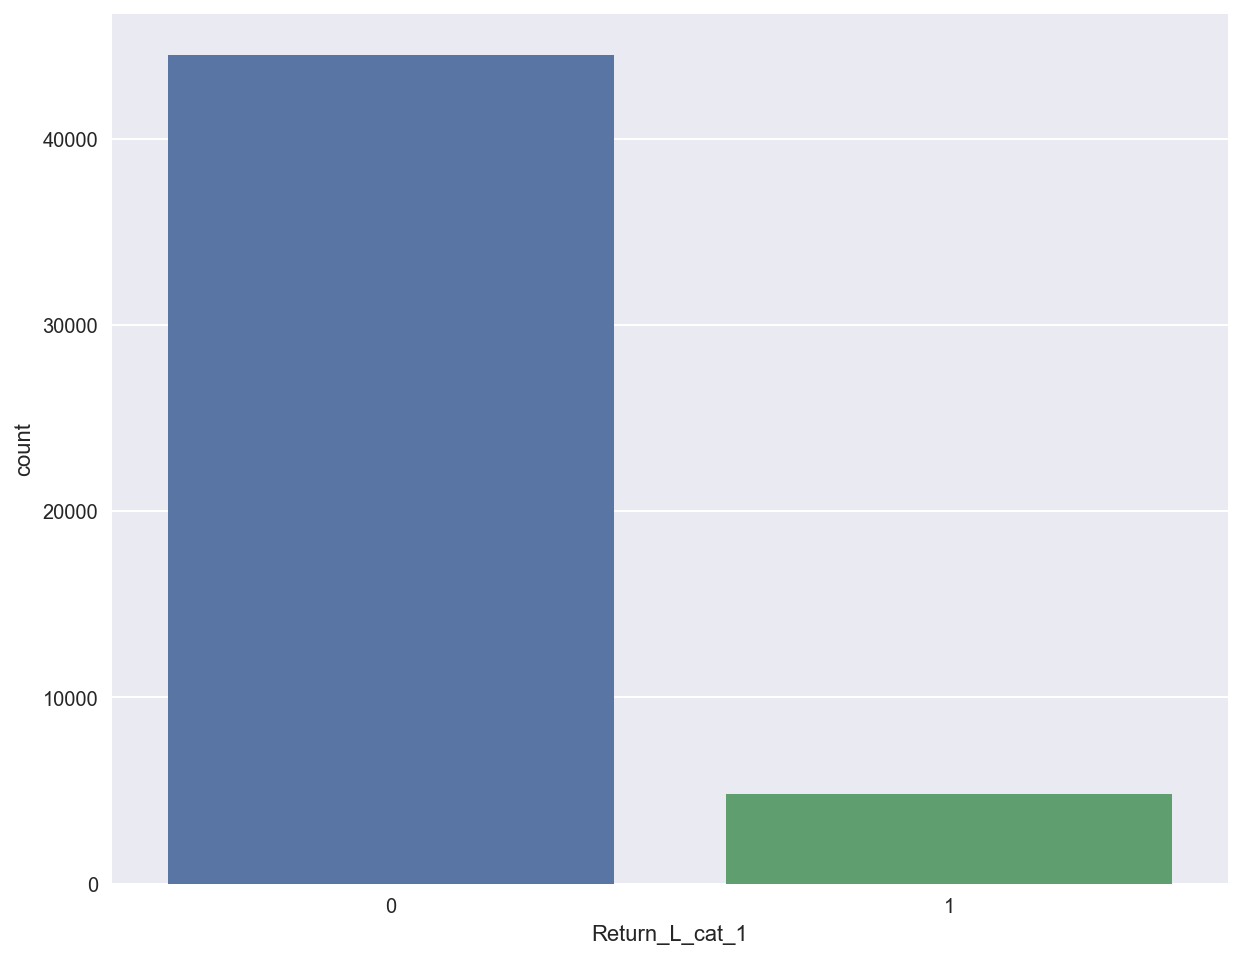

In [19]:
class_distribution(df, 'Return_L_cat_1')

В выборке всего 10% таких баров, 4833 шт

### Категориальный признак показывающий, что текущий бар вырос минимум на 1% и что нижняя тень не более 0.25%

In [20]:
df['Return_L_cat_1_0_25'] = np.where((df['Log_Return'] >= 0.01) & (df['Low_Shad_log'] <= 0.0025), 1, 0)

,%,Count
Class,,
1,5.23,2580
0,94.77,46757


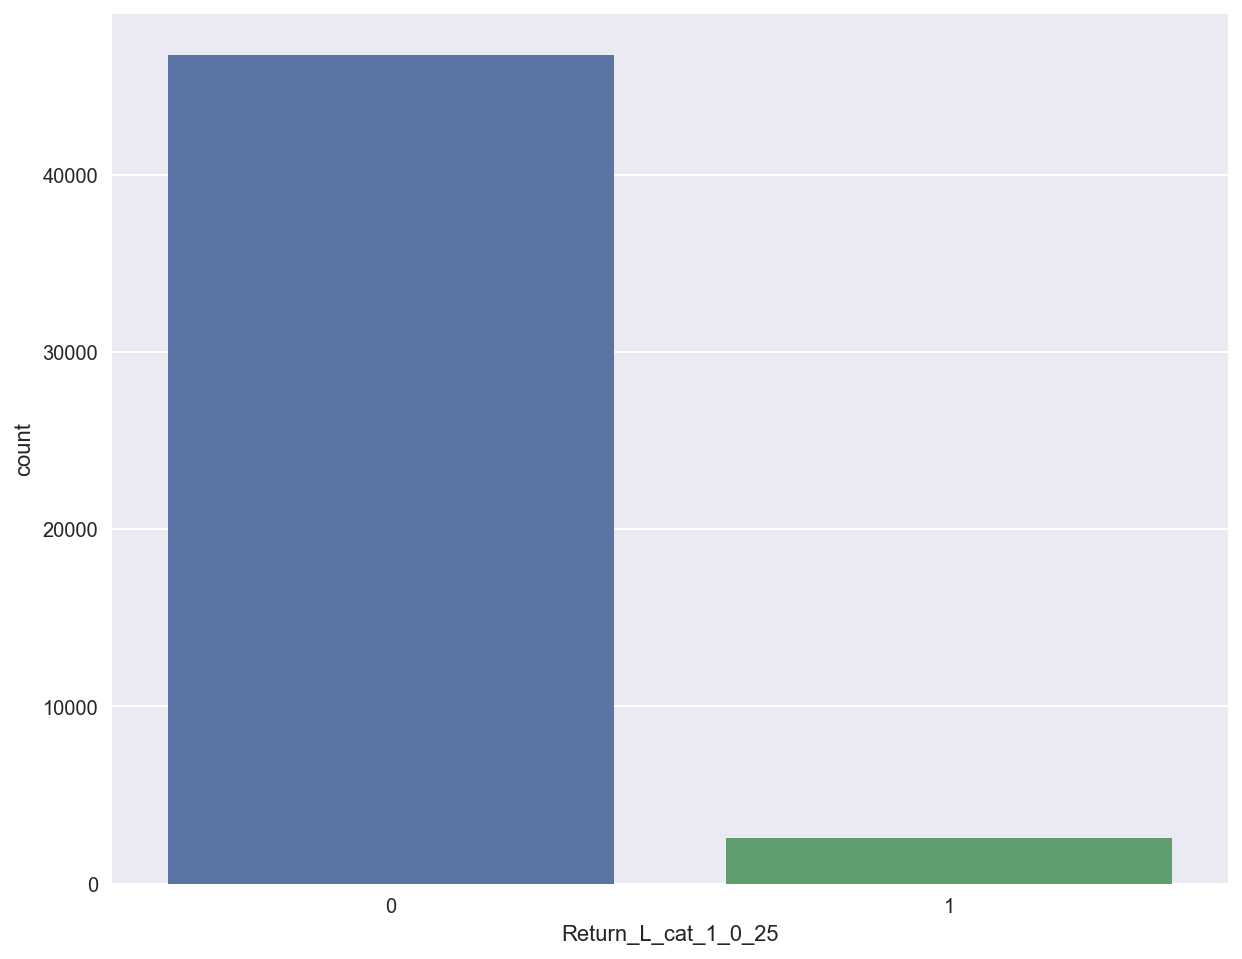

In [21]:
class_distribution(df, 'Return_L_cat_1_0_25')

В выборке всего 5% таких баров, 2580 шт

In [22]:
print(f"Частота появления такого бара, каждые {(df.shape[0] // df['Return_L_cat_1_0_25'].value_counts()[1])} часов")

Частота появления такого бара, каждые 19 часов


Сколько всего дней на истории

In [23]:
(df.index[-1] - df.index[0]).days

2060

### Категориальный признак показывающий, что у текущего бара верхняя тень минимум 1% и что нижняя тень не более 0.25%
Т.е. это тот случай когда я мог зацепить тейк и не зацепить стоп при соотношении доходность/риск как 4к1

In [24]:
df['H_1_L_0_25'] = np.where((df['High_Shad_log'] >= 0.01) & (df['Low_Shad_log'] <= 0.0025), 1, 0)

,%,Count
Class,,
1,9.42,4650
0,90.58,44687


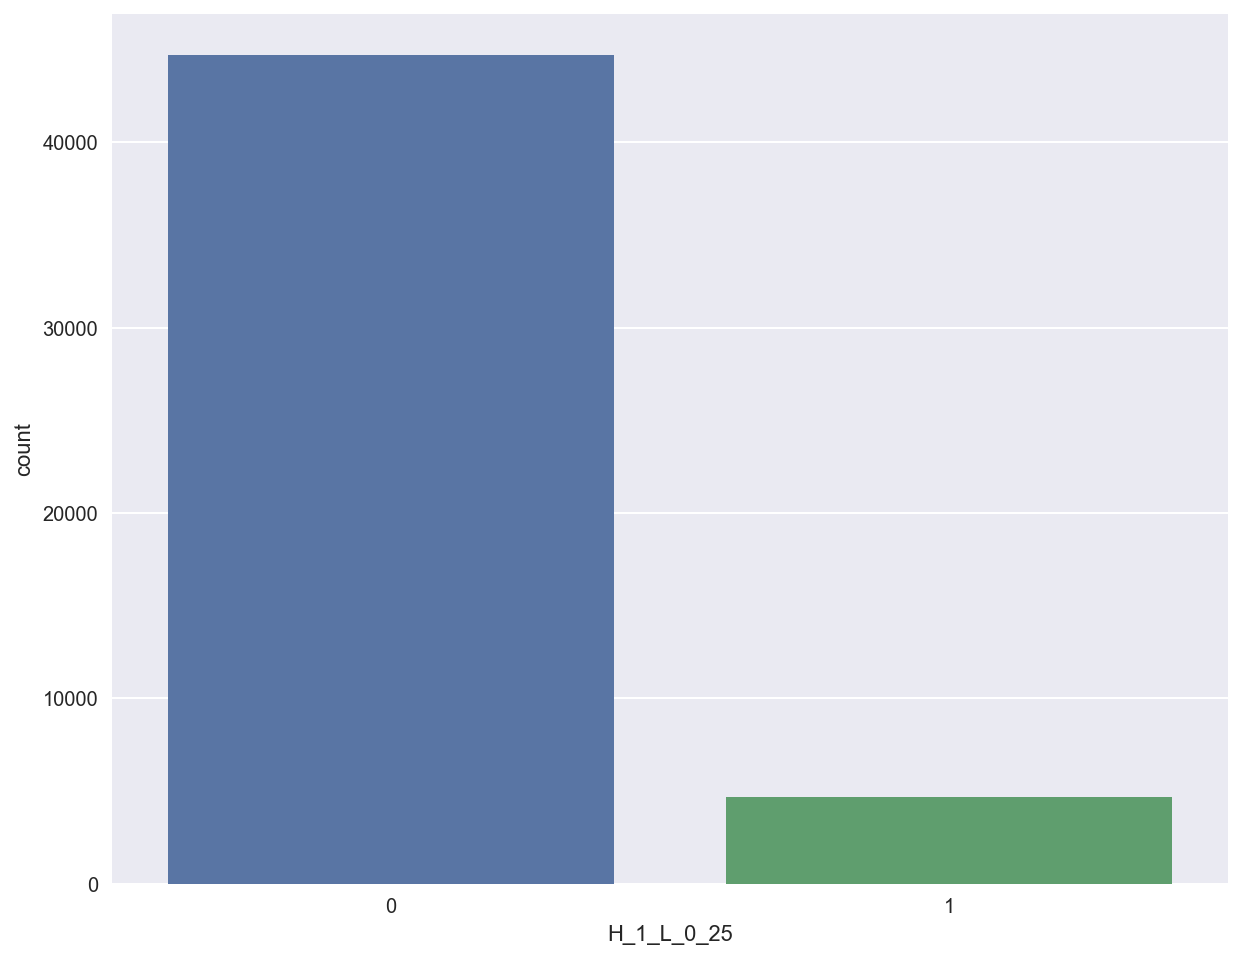

In [25]:
class_distribution(df, 'H_1_L_0_25')

Таких вариантов стало больше, 9% или 4650 баров

In [26]:
print(f"Частота появления такого бара, каждые {(df.shape[0] // df['H_1_L_0_25'].value_counts()[1])} часов")

Частота появления такого бара, каждые 10 часов


### Посмотрим на такие случаи с начала года

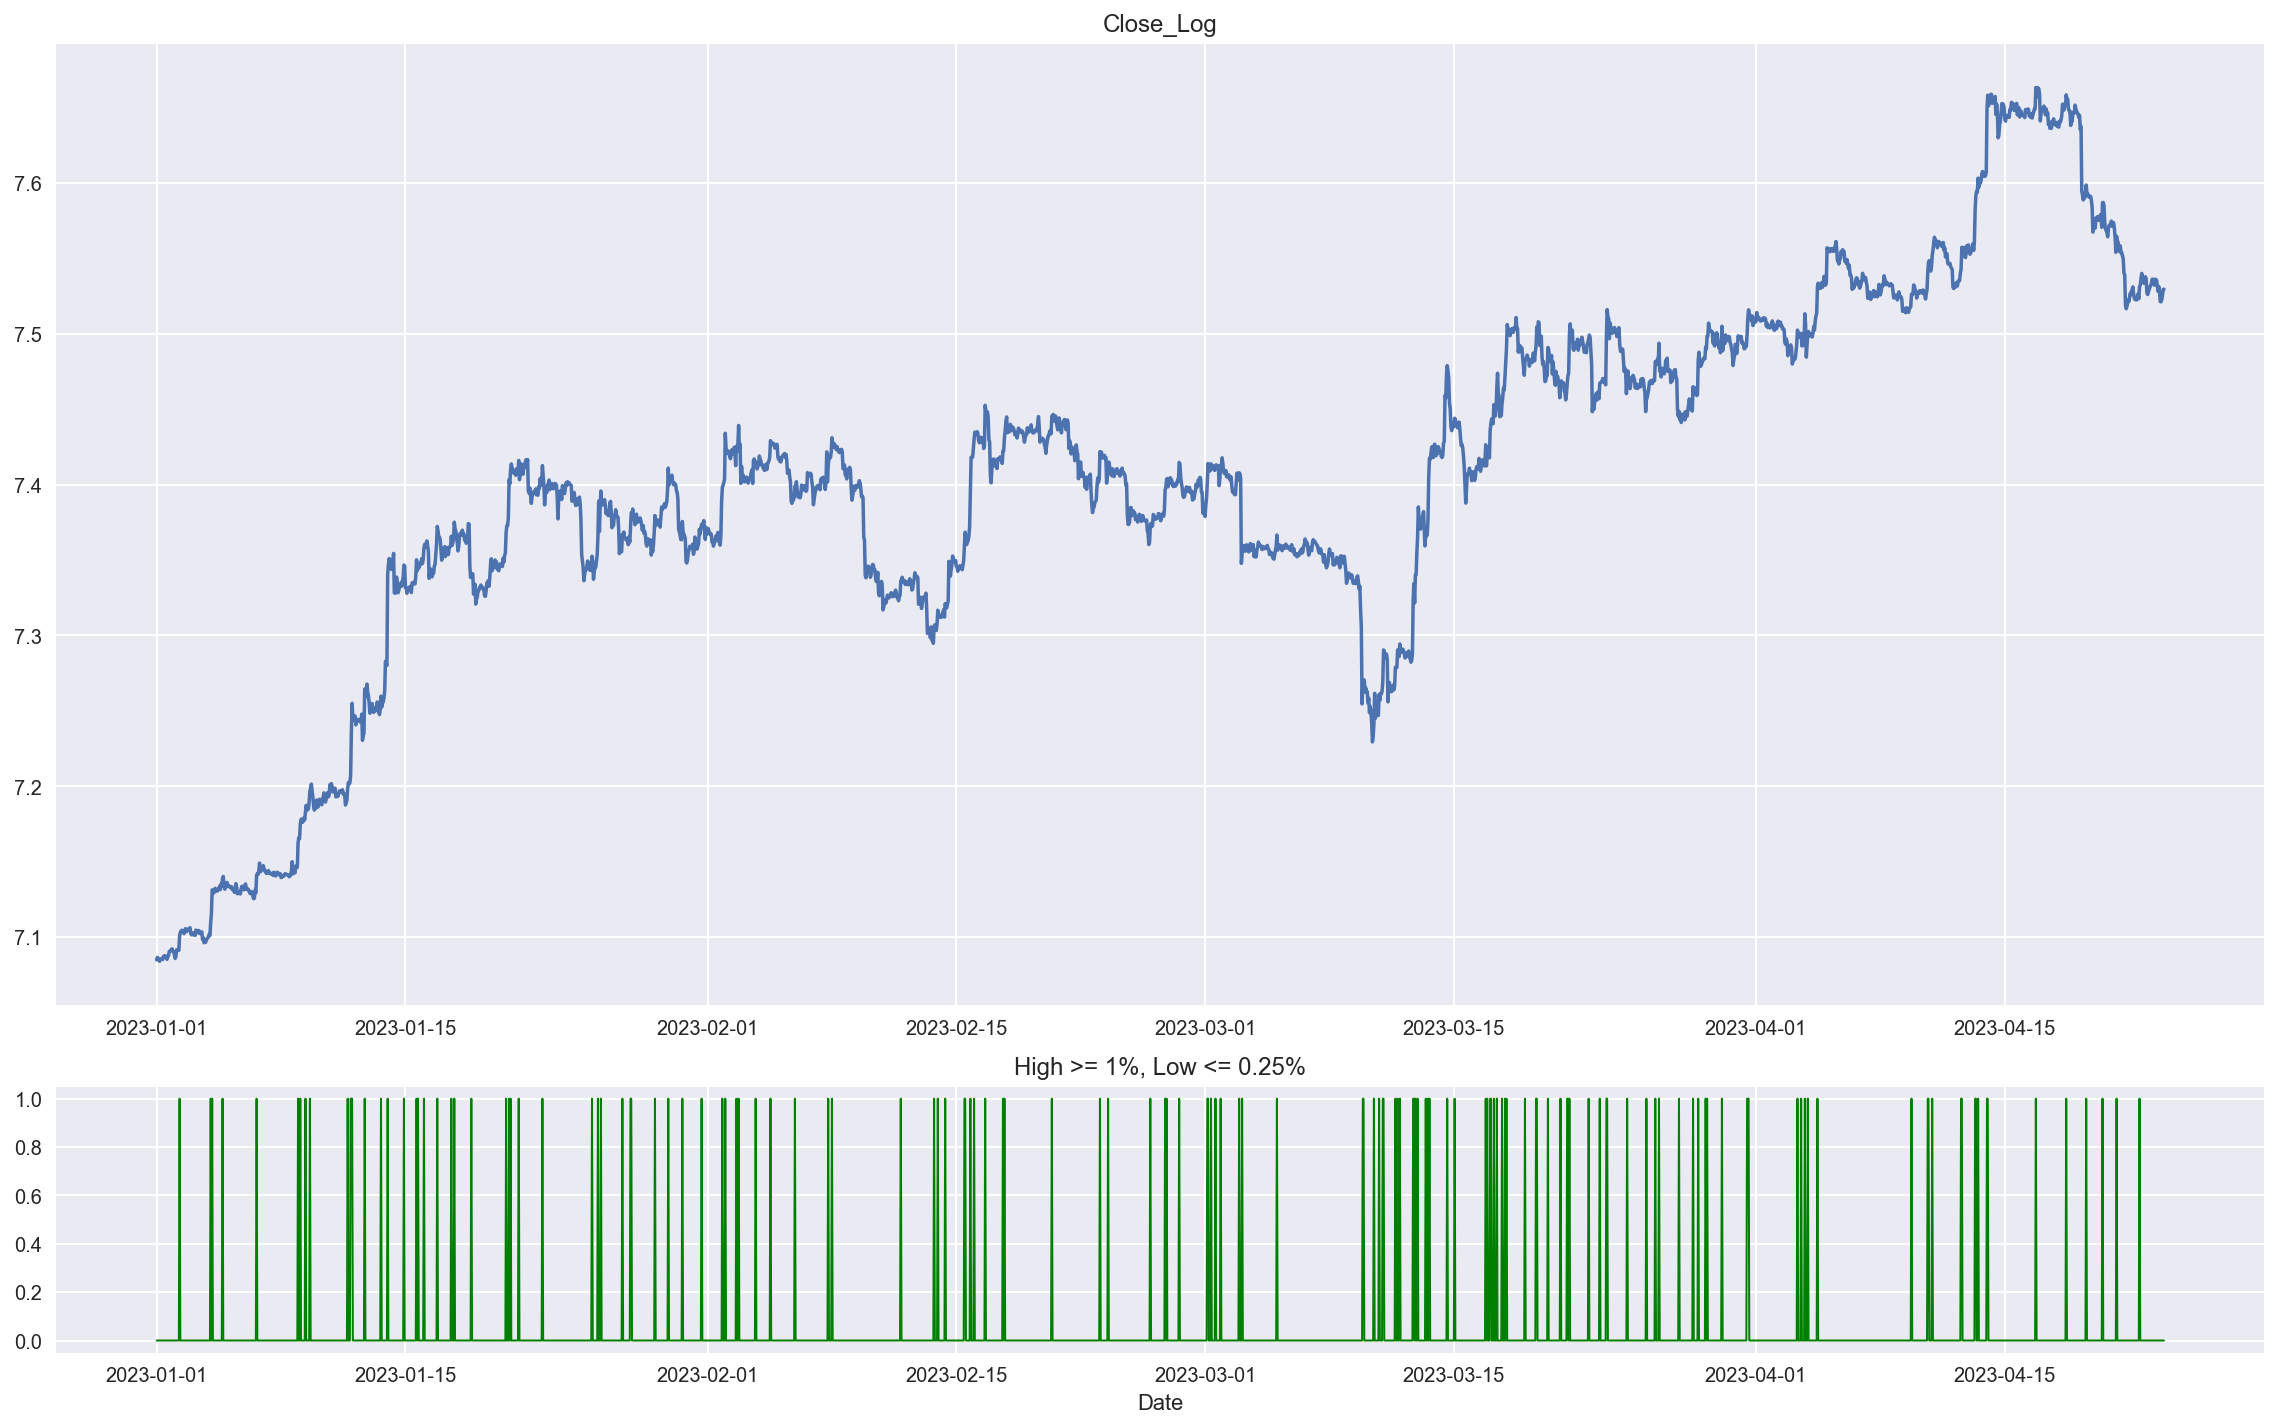

In [47]:
# If need to plot not all data
df_to_plot = df[df.index >= '2023-01-01']
# df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Create a grid with 5 rows
gs = gridspec.GridSpec(4, 1)

# Create a subplot for the first plot occupying 3/5 of the grid
ax0 = plt.subplot(gs[:3])

# Create a subplot for the second plot occupying 1/5 of the grid
ax1 = plt.subplot(gs[3:])

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Close_log'].to_numpy()
_1 = df_to_plot['H_1_L_0_25'].to_numpy()

ax0.plot(ind, _0)
ax0.set_title('Close_Log')

ax1.plot(ind, _1, color='green', linewidth=1)
ax1.set_title('High >= 1%, Low <= 0.25%')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [28]:
print(f"Частота появления такого бара, каждые {(df_to_plot.shape[0] // df_to_plot['H_1_L_0_25'].value_counts()[1])} часов")

Частота появления такого бара, каждые 18 часов


С начала года такие бары стали появляться почит в два раза реже, каждые 18 часов, вместо 10 на всем датасете

## SHORT: Create Return as Category Target

### Категориальный признак показывающий что текущий бар упал

In [29]:
df['Return_S_cat'] = np.where(df['Log_Return'] <= 0, 1, 0)

,%,Count
Class,,
1,49.58,24460
0,50.42,24877


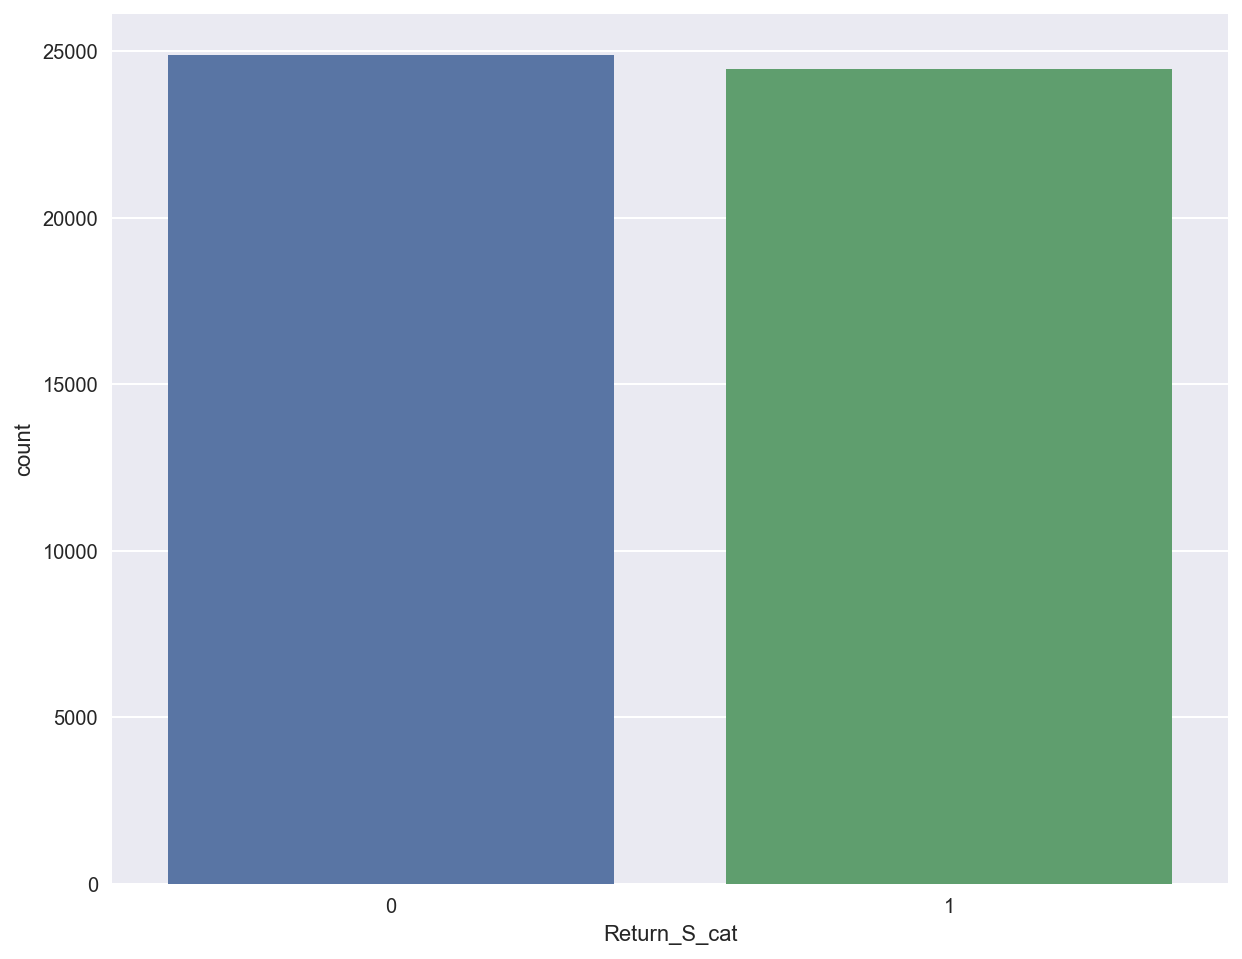

In [30]:
class_distribution(df, 'Return_S_cat')

В таком виде классы полностью сбалансированны, посмотрим что будет после разделения

### Категориальный признак показывающий, что текущий бар упал минимум на 1% и что верхняя тень не более 0.25%

In [31]:
df['Return_S_cat_1_0_25'] = np.where((df['Log_Return'] <= -0.01) & (df['High_Shad_log'] <= 0.0025), 1, 0)

,%,Count
Class,,
1,5.17,2552
0,94.83,46785


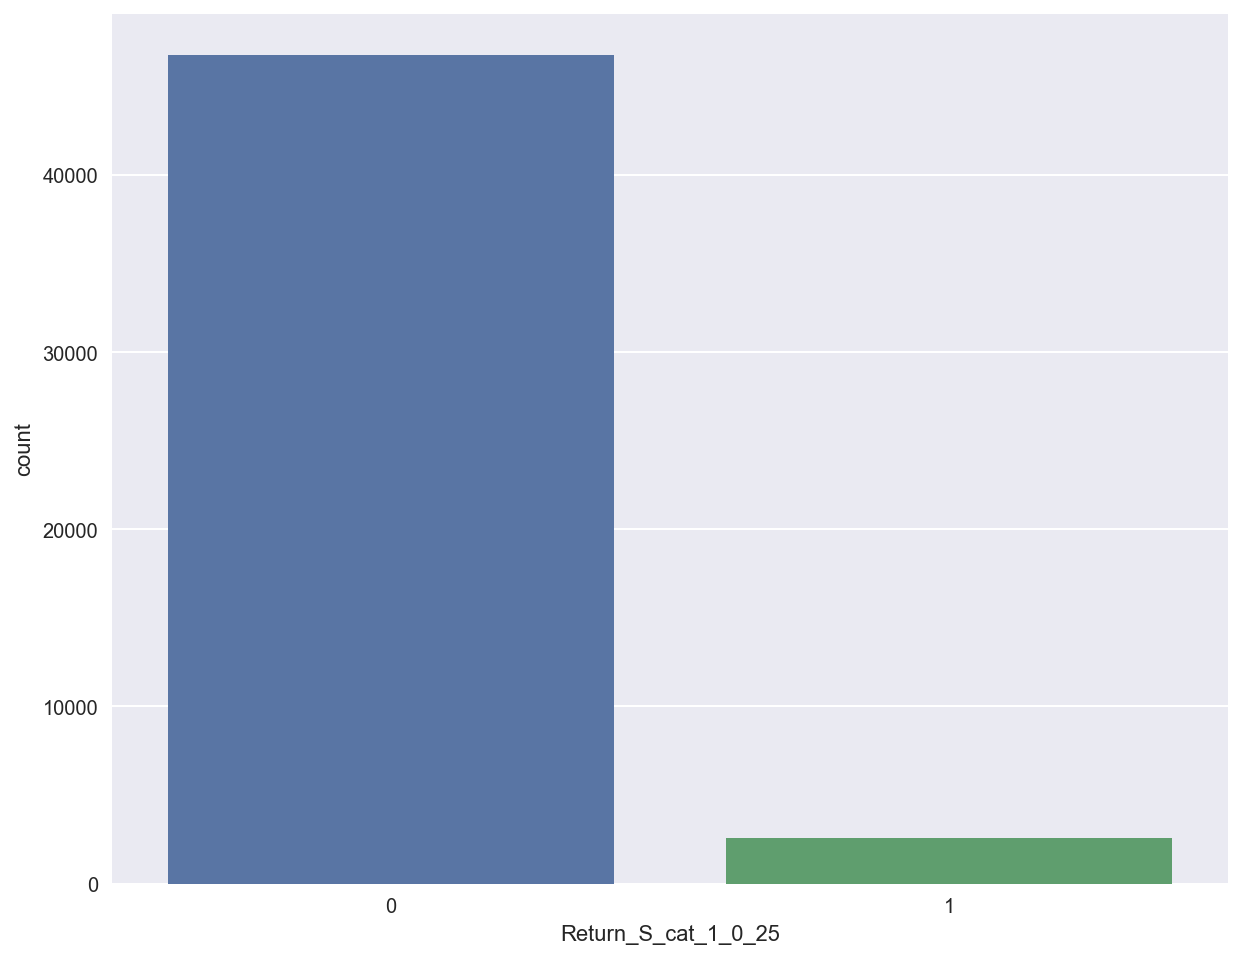

In [32]:
class_distribution(df, 'Return_S_cat_1_0_25')

В выборке всего 5% таких баров, опять же, примерно столько же как и для лонгов

In [33]:
print(f"Частота появления такого бара, каждые {(df.shape[0] // df['Return_S_cat_1_0_25'].value_counts()[1])} часов")

Частота появления такого бара, каждые 19 часов


Сколько всего дней на истории

In [34]:
(df.index[-1] - df.index[0]).days

2060

### Категориальный признак показывающий, что у текущего бара нижняя тень минимум 1% и что верхняя тень не более 0.25%
Т.е. это тот случай когда я мог зацепить тейк и не зацепить стоп при соотношении доходность/риск как 4к1

In [35]:
df['L_1_H_0_25'] = np.where((df['Low_Shad_log'] >= 0.01) & (df['High_Shad_log'] <= 0.0025), 1, 0)

,%,Count
Class,,
1,9.91,4888
0,90.09,44449


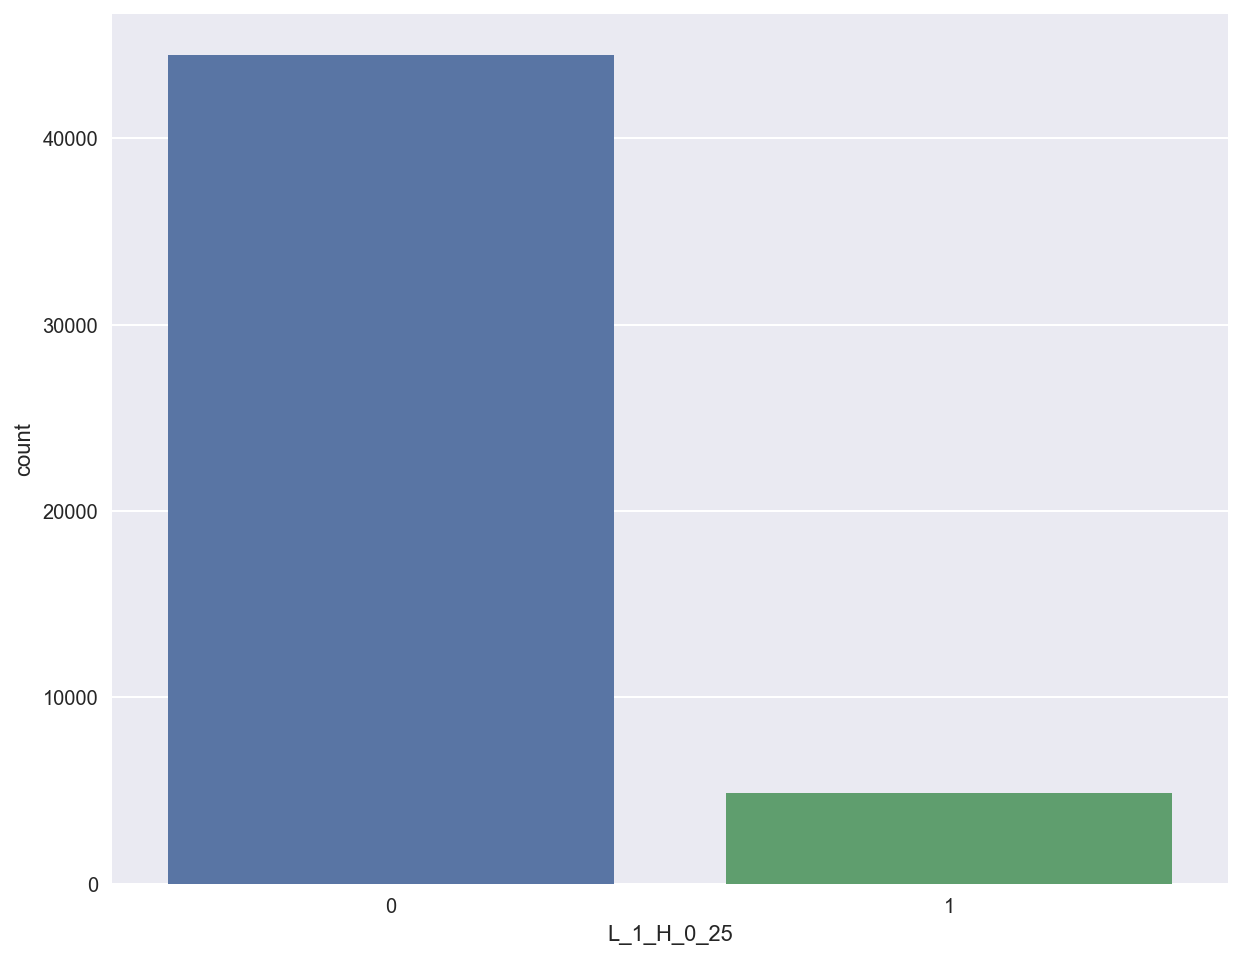

In [36]:
class_distribution(df, 'L_1_H_0_25')

Таких вариантов стало больше, 9% или 4888 баров. Опять же, очень близко к тому что наблюдается для лонгов. Практически тоже количество.

In [37]:
print(f"Частота появления такого бара, каждые {(df.shape[0] // df['L_1_H_0_25'].value_counts()[1])} часов")

Частота появления такого бара, каждые 10 часов


### Посмотрим на такие случаи с начала года

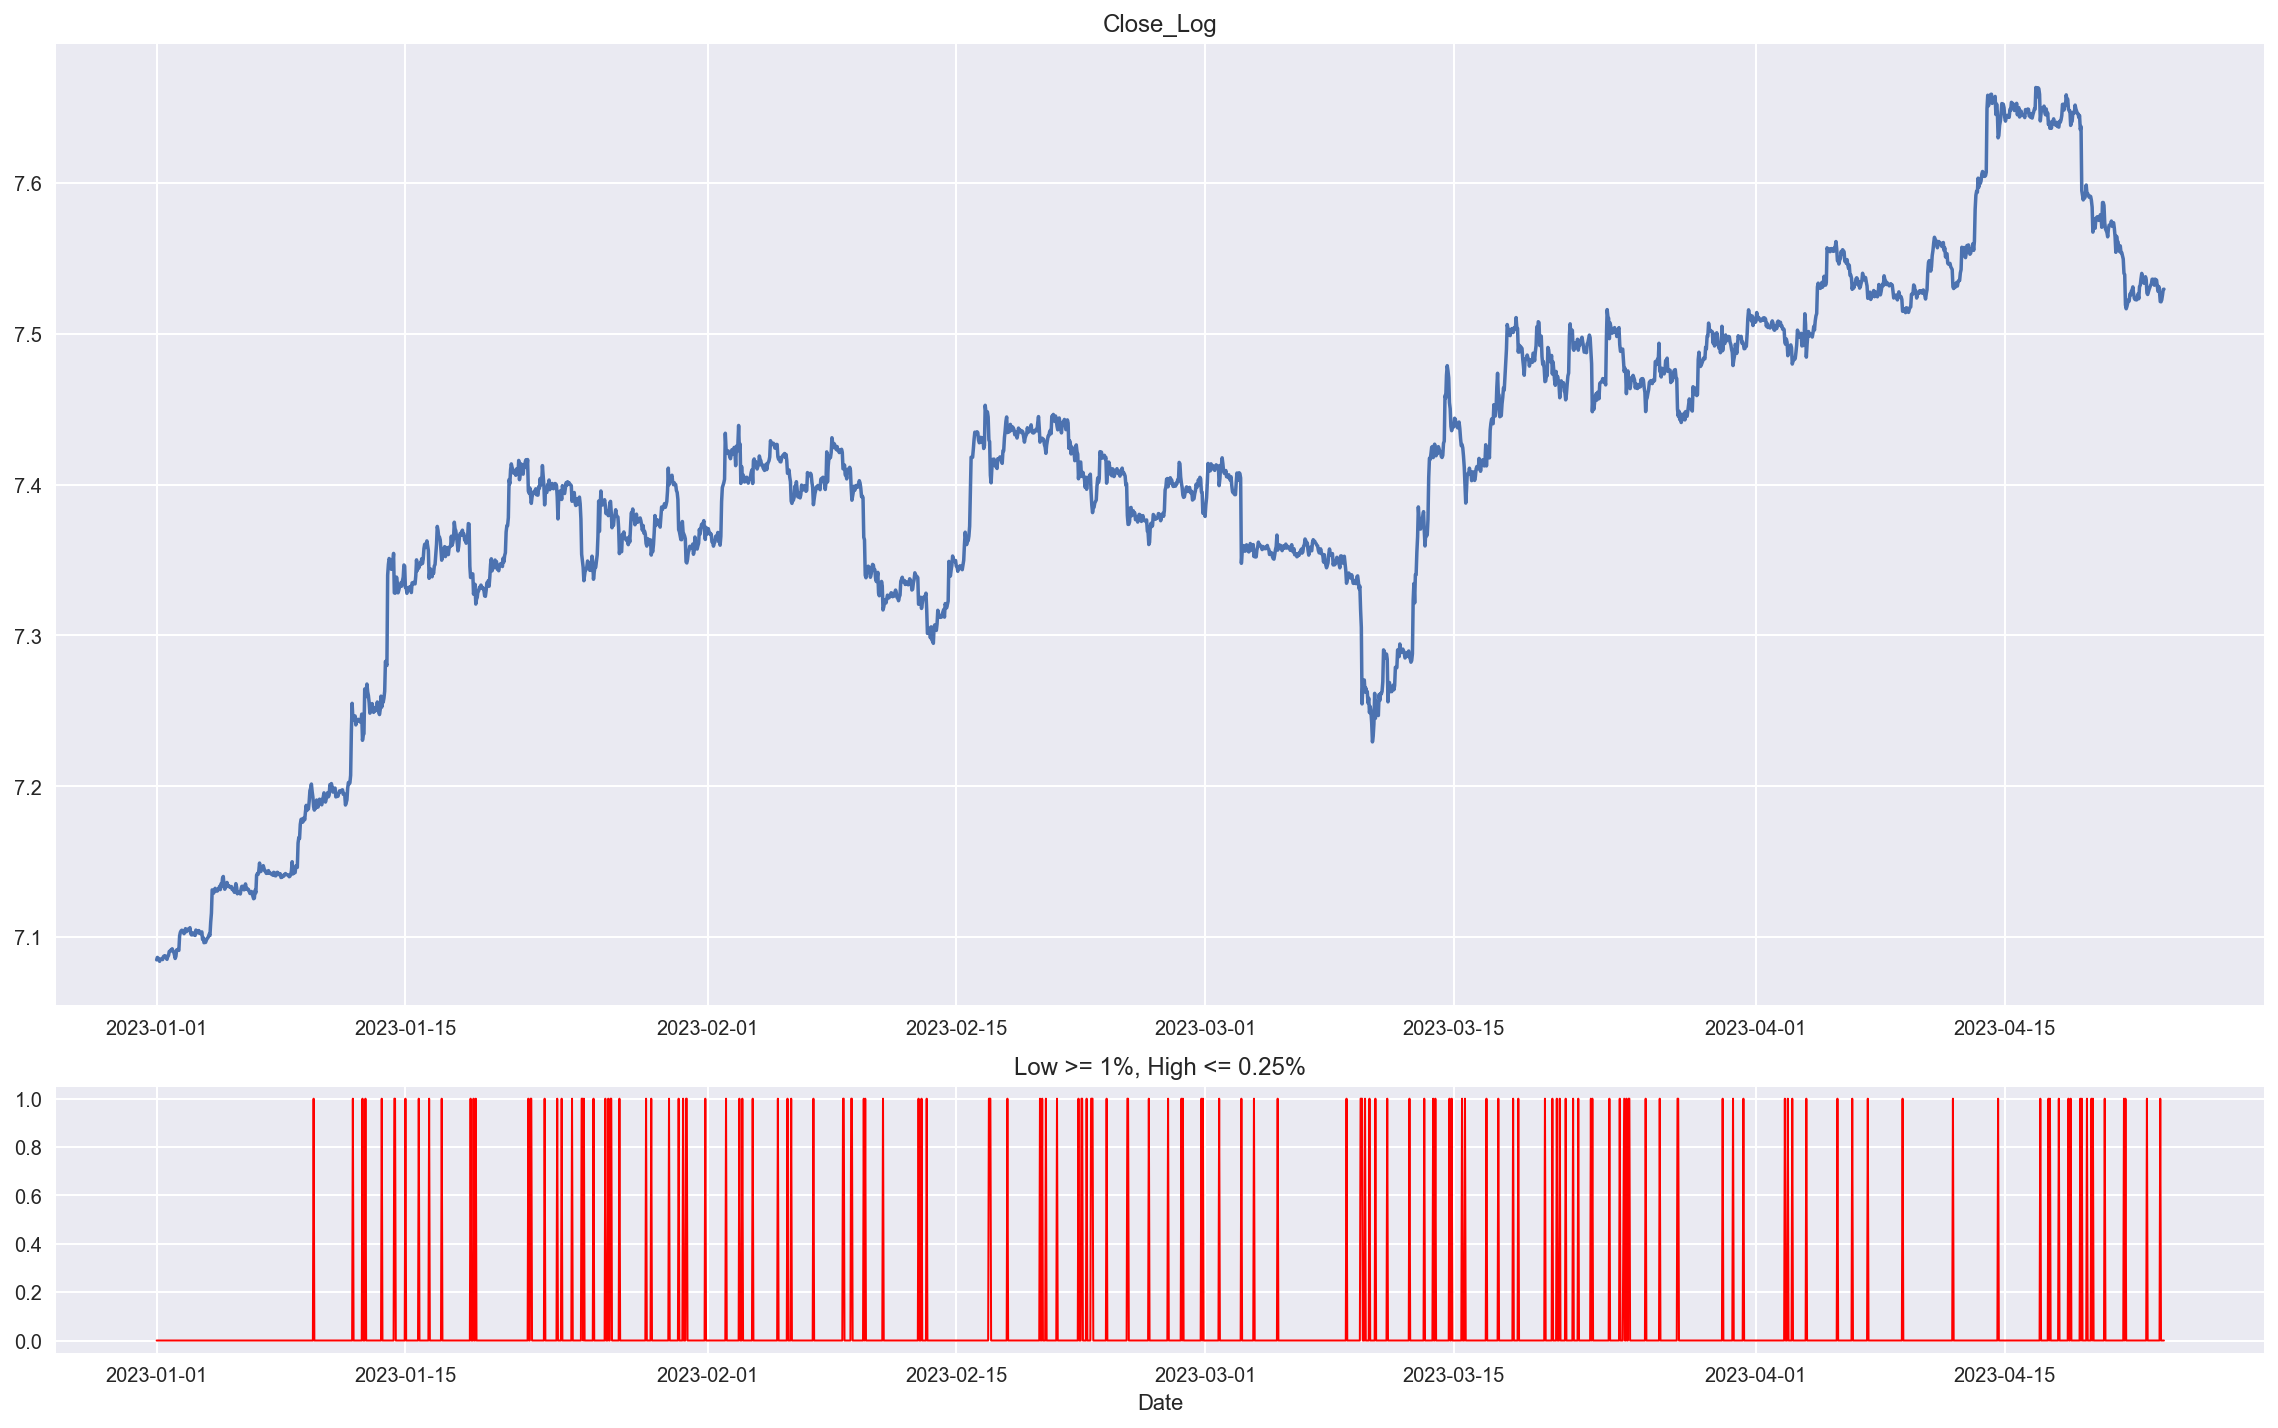

In [46]:
# If need to plot not all data
df_to_plot = df[df.index >= '2023-01-01']
# df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Create a grid with 5 rows
gs = gridspec.GridSpec(4, 1)

# Create a subplot for the first plot occupying 3/5 of the grid
ax0 = plt.subplot(gs[:3])

# Create a subplot for the second plot occupying 1/5 of the grid
ax1 = plt.subplot(gs[3:])

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Close_log'].to_numpy()
_1 = df_to_plot['L_1_H_0_25'].to_numpy()

ax0.plot(ind, _0)
ax0.set_title('Close_Log')

ax1.plot(ind, _1, color='red', linewidth=1)
ax1.set_title('Low >= 1%, High <= 0.25%')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### Визуализирую оба направления на графике

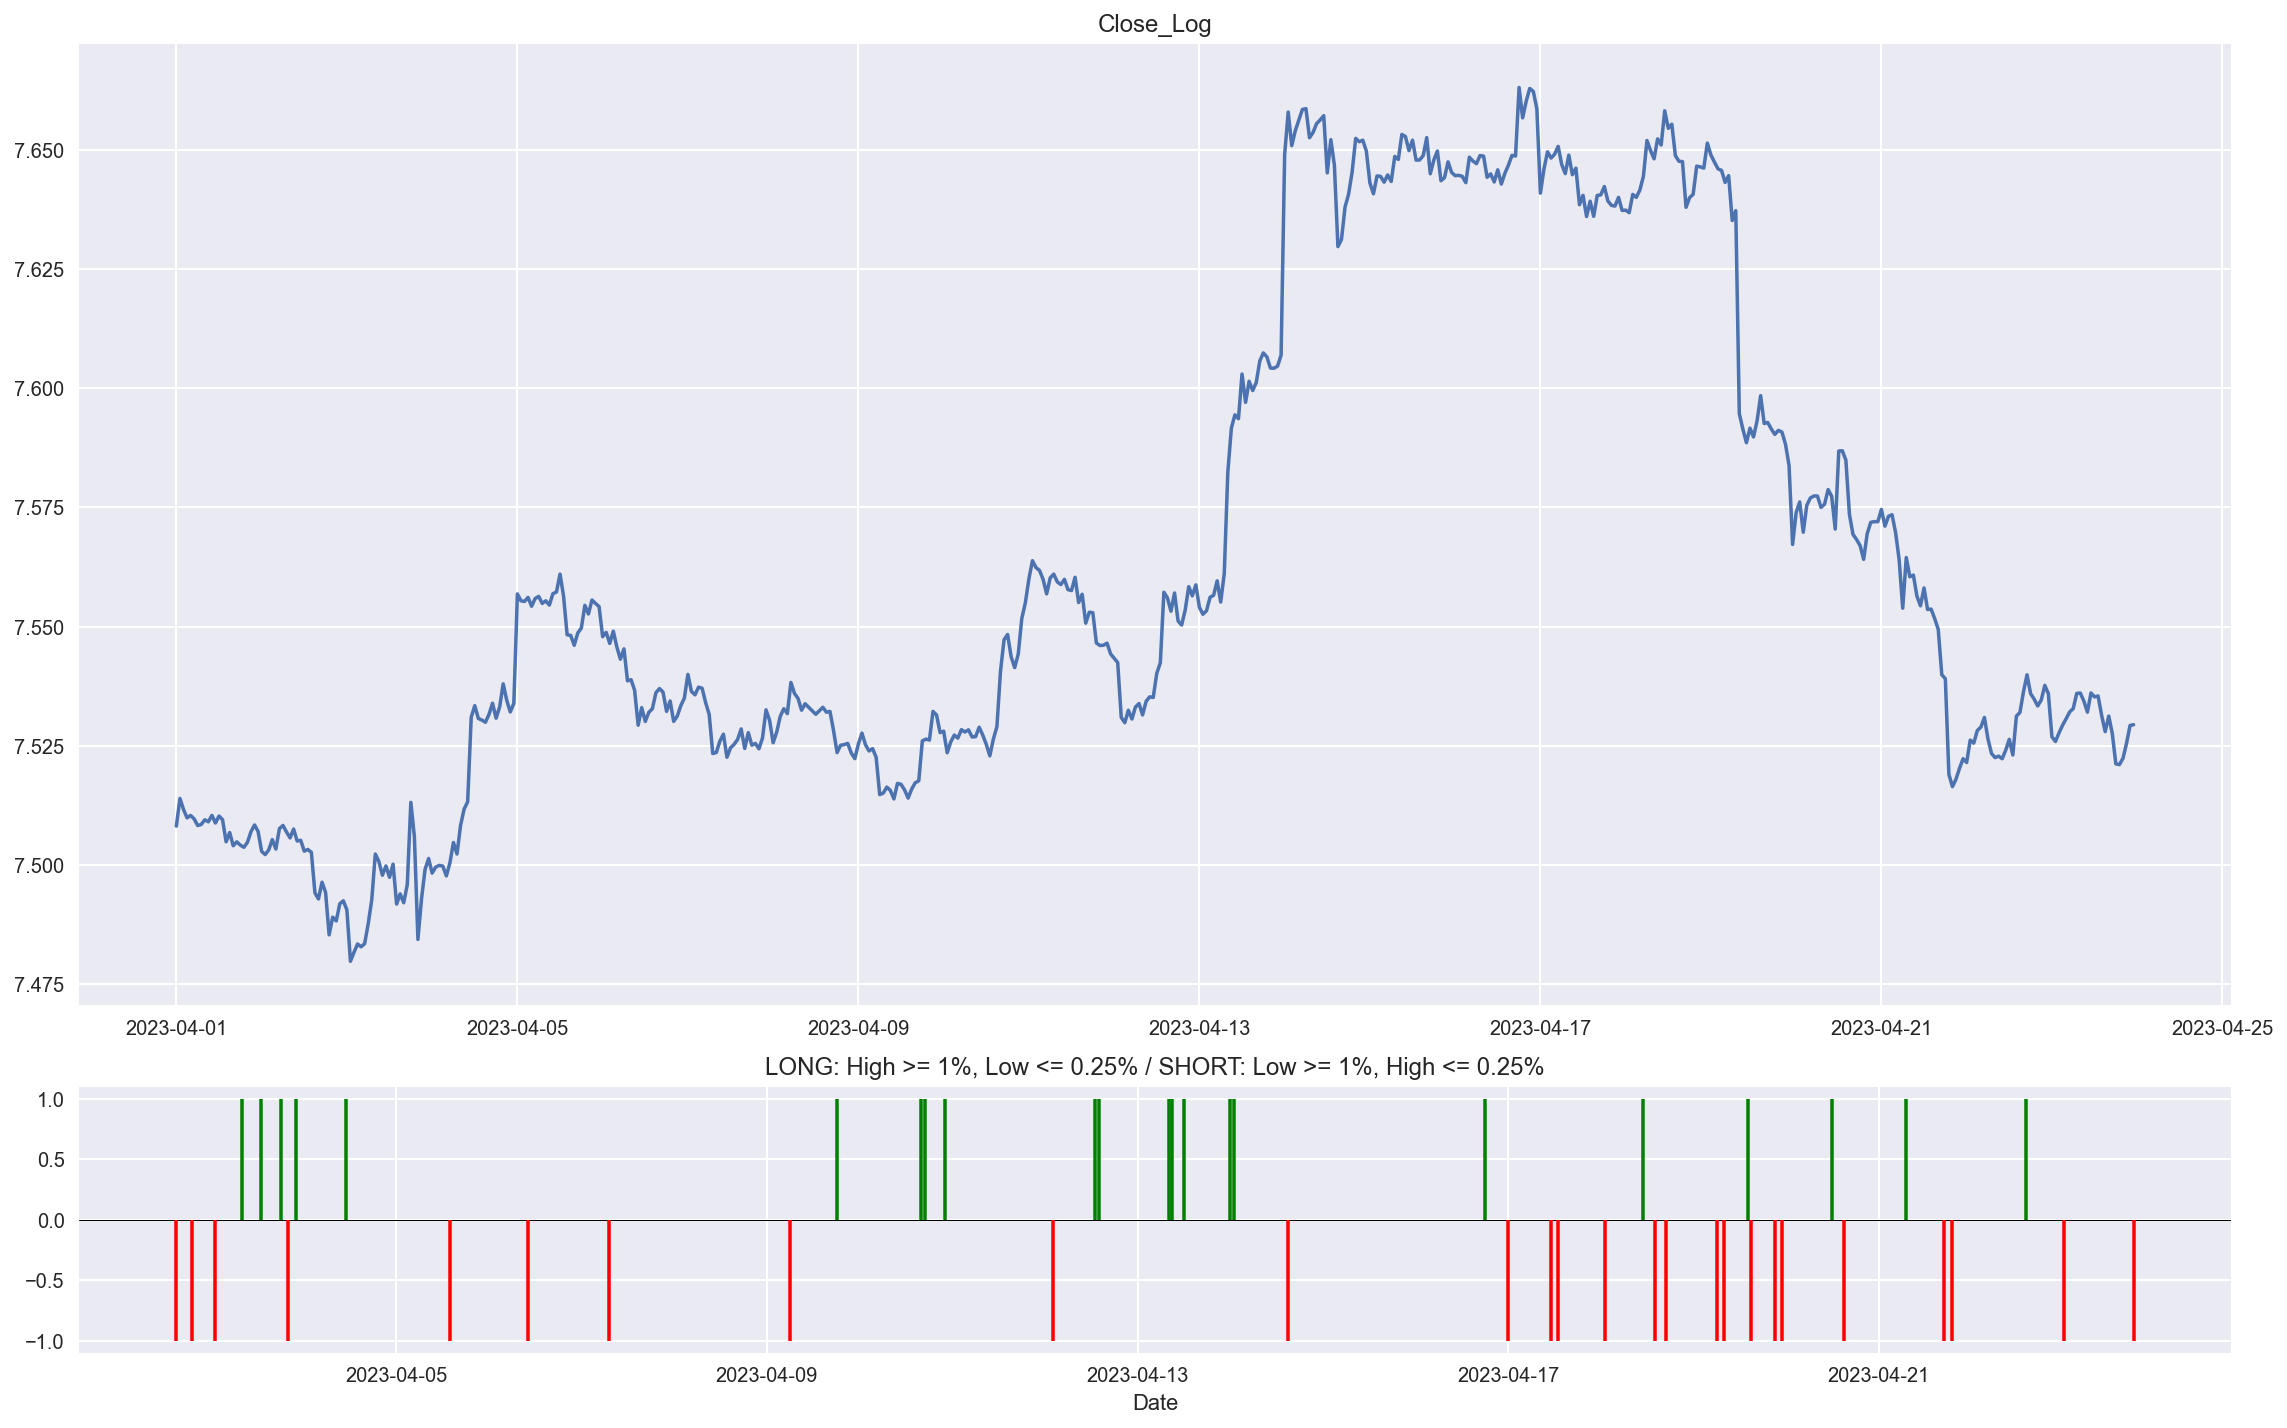

In [39]:
# If need to plot not all data
df_to_plot = df[df.index >= '2023-04-01']
# df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Create a grid with 5 rows
gs = gridspec.GridSpec(4, 1)

# Create a subplot for the first plot occupying 3/5 of the grid
ax0 = plt.subplot(gs[:3])

# Create a subplot for the second plot occupying 1/5 of the grid
ax1 = plt.subplot(gs[3:])

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Close_log'].to_numpy()

ax0.plot(ind, _0)
ax0.set_title('Close_Log')

ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.vlines(x=df_to_plot[df_to_plot['H_1_L_0_25'] == 1].index, color='green', ymin=0, ymax=1)
ax1.vlines(x=df_to_plot[df_to_plot['L_1_H_0_25'] == 1].index, color='red', ymin=-1, ymax=0)
ax1.set_title('LONG: High >= 1%, Low <= 0.25% / SHORT: Low >= 1%, High <= 0.25%')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Количество кейсов на заданной для графика длине истории

In [40]:
df_to_plot[['H_1_L_0_25', 'L_1_H_0_25']].sum()

H_1_L_0_25    22
L_1_H_0_25    26
dtype: int64

### Провека TARGETs на стационарность

In [41]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [42]:
adf(df['H_1_L_0_25'])

Test-Statistic: -25.627604467021104
P-Value: 0.0
Stationary!


In [43]:
adf(df['L_1_H_0_25'])

Test-Statistic: -22.98682177889395
P-Value: 0.0
Stationary!


Конечно ряды потенциальных целевых признаков стационарны

С начала года частота появления таких баров 18 часов, при том что на всей выборке это значение 10 часов

Способ формирования Target Category Feature это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4


Так же в качестве гиперпараметра можно рассматривать исходный датафрейм:
- 30min
- 1H
- 2H
- 3H
- 4H

In [44]:
# тест